In [54]:
# Imports
from utils import (plot_mean_bar,get_target,categorical_cardinality,categorical_mean,numerical_mean)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path
import os
from IPython.display import display
from sklearn import set_config
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Notebook Settings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [8, 5]
set_config(display="diagram")

############# Caminhos dos Arquivos de Entrada ########################

input_folder = ".."
studentInfo = "studentInfo.csv"

#######################################################################

############## Parametros Gerais ############################

TEST_SIZE = 0.10
RANDOM_SEED = 42


**Disclaimer**: O texto em português contem diversas omissões de acentuação devido a escrito ao teclado nórdico que uso. Deste modo, escrever å torna-se mais fácil do que escrever ç. Perdoem-me :)

# 1. Primeiro Experimento

Nosso primeiro modelo (experimento) leva em conta apenas os atributos contidos no *dataset* **studentInfo**. 

## 1.1 Exploração do  *studentInfo Dataset*

Começaremos explorando o dataset studentInfo pois o temos como a espinha dorsal do primeiro modelo que construiremos para resolver a questão de negócios que nos propusemos a resolver: **Quais estudantes falharão no Exame Final?**


In [2]:
info = pd.read_csv(Path(input_folder,studentInfo),low_memory=False)

In [3]:
f'Info Dataset Contem {info.shape[0]} linhas e {info.shape[1]} colunas'

'Info Dataset Contem 32593 linhas e 12 colunas'

In [4]:
info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [5]:
# Maybe some outliers?
info.describe()

,id_student,num_of_prev_attempts,studied_credits
count,3.259300e+04,32593.000000,32593.000000
mean,7.066877e+05,0.163225,79.758691
std,5.491673e+05,0.479758,41.071900
min,3.733000e+03,0.000000,30.000000
25%,5.085730e+05,0.000000,60.000000
50%,5.903100e+05,0.000000,60.000000
75%,6.444530e+05,0.000000,120.000000
max,2.716795e+06,6.000000,655.000000


Maioria dos Estudantes assistindo aos modulos pela primeira vez, como esperado. Ha um valor máximo de 6 tentativas anteriores que chama a atenção. Vamos investigar.

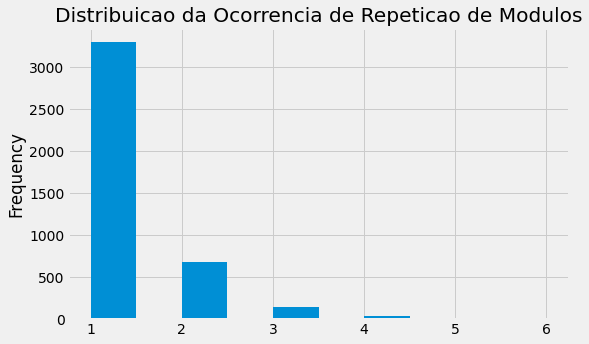

In [6]:
ax = (
       info.query("num_of_prev_attempts >=1")['num_of_prev_attempts']
       .plot(kind = 'hist')
     )

_= ax.set_title("Distribuicao da Ocorrencia de Repeticao de Modulos")
_= ax.set_xticks(np.arange(1,7))

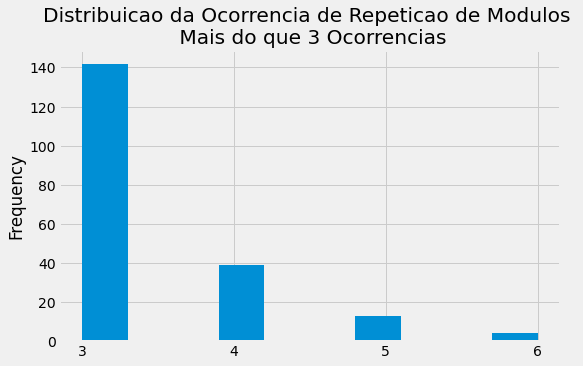

In [7]:
ax = (
       info.query("num_of_prev_attempts >=3")['num_of_prev_attempts']
       .plot(kind = 'hist')
     )

_= ax.set_title("Distribuicao da Ocorrencia de Repeticao de Modulos \n Mais do que 3 Ocorrencias")
_= ax.set_xticks(np.arange(3,7))

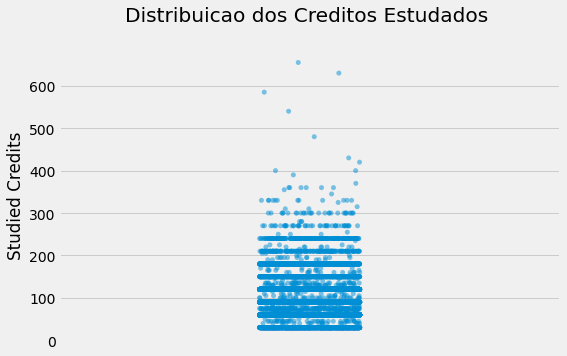

In [8]:
ax = sns.stripplot(y = info['studied_credits'],alpha = 0.5)
_= ax.set_ylabel("Studied Credits")
_= ax.set_title("Distribuicao dos Creditos Estudados \n")

Alguns pontos claramente destoantes (possivelmente *outliers*, pois muito fora da IQR), mas sem grande motivo para nos preocuparmos, pois utilizaremos Random Forests na primeira versão da solução, algoritmo que não impõem nenhuma hipótese quanto a distribuição dos atributos bem como bastante resistente a outliers.

In [9]:
duplicated_mask = info['id_student'].duplicated(keep = False)
info_duplicated = info[duplicated_mask]
info_duplicated.sort_values('id_student').head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
14395,DDD,2013J,8462,M,London Region,HE Qualification,30-40%,55<=,0,90,N,Withdrawn
17560,DDD,2014J,8462,M,London Region,HE Qualification,30-40%,55<=,1,60,N,Withdrawn
13091,DDD,2013B,24213,F,East Anglian Region,A Level or Equivalent,40-50%,0-35,0,90,N,Withdrawn
16332,DDD,2014B,24213,F,East Anglian Region,A Level or Equivalent,40-50%,0-35,1,60,N,Pass
2517,BBB,2013J,25629,F,Scotland,Lower Than A Level,20-30%,0-35,0,120,N,Withdrawn


In [10]:
f'{info_duplicated.query("num_of_prev_attempts >=1").shape[0]} estudantes repetiram modulos ao menos uma vez'

'1667 estudantes repetiram modulos ao menos uma vez'

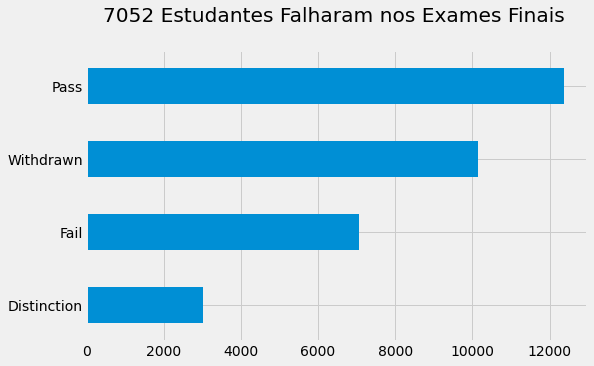

In [11]:
final_results = Counter(info['final_result'])
ax = (
       info
      .final_result
      .value_counts(ascending = True)
      .plot(kind = "barh")
     )

_= ax.set_ylabel("")
_= ax.set_title(str(final_results['Fail']) + ' Estudantes Falharam nos Exames Finais \n')

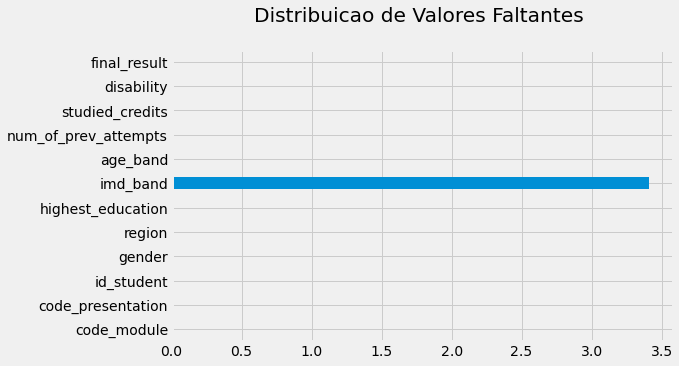

In [12]:
# Checando Valores Faltantes
ax = (
      info
     .isna()
     .mean()
     .mul(100)
     .plot(kind = "barh")
     )
_= ax.set_title("Distribuicao de Valores Faltantes \n")

In [13]:
# Numero de Niveis Distintos das Variaveis Categoricas
categorical_cardinality(info)

{'code_module': 7,
 'code_presentation': 4,
 'gender': 2,
 'region': 13,
 'highest_education': 5,
 'imd_band': 10,
 'age_band': 3,
 'disability': 2,
 'final_result': 4}

Nenhuma variável com cardinalidade proibitivamente alta, o que resultara em mais opções para escolher o *encoding* a ser usado na modelagem. *One-hot-encoding* não sera caro computacionalmente e lida bem com categorias desconhecidas que podem aparecer em produção :)

### 1.1.1 Modelagem/Limpeza

A variável *code_presentation* nao sera útil com o *encoding* atual, pois saber o ano em que o aluno realizou o modulo nao seria relevante no momento da inferência. Contudo os códigos **J/B** tem valor, pois a época do ano em que o modulo foi cursado pode conter poder preditivo.

In [14]:
info_clean = (info
 .assign(module_code = lambda df_:df_['code_presentation']
         .str
         .split('([A-Z])',expand = True)[1])
             )

assert list(info_clean['module_code'].unique()) == ['J', 'B'] 

In [15]:
info_clean['module_code'].sample(5)

21090    B
28039    J
6183     B
27823    J
14033    B
Name: module_code, dtype: object

Para respondermos nossa questão de negocio (Quais estudantes falharão no Exame Final?), precisaremos reagrupar as categorias *Pass*/*Distinction* do alvo em Pass, alem de nao usarmos as observações em que os estudantes desistiram dos módulos (*Withdrawn*). Em experimentos futuros podemos rever essa hipotese e incorporar os dados coletados dos modulos em que o aluno desistiu.

In [16]:
# Primeira Tabela de Dados Feita :) 
feature_store = info_clean 

# Eliminadas as Observacoes em que o estudante desistiu e Alvo mapeado para (Pass/Fail)
data_first_experiment = (
                      feature_store
                      .query("final_result != 'Withdrawn'")
                      .pipe(get_target,target_name = 'final_result')
                      .drop(['id_student','code_presentation'],axis = 1)
                     )

assert list(data_first_experiment['final_result'].unique()) == ['Pass', 'Fail'] 

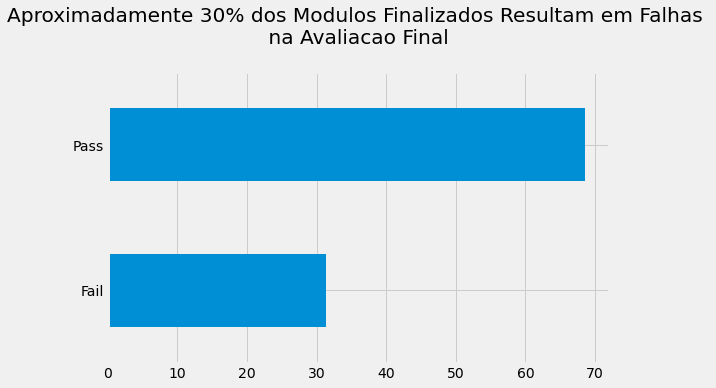

In [17]:
# Distribuicao do Alvo
ax = (
      data_first_experiment['final_result']
     .value_counts(normalize = True,ascending = True)
     .mul(100)
     .plot(kind = 'barh')
     )

_= ax.set_title("Aproximadamente 30% dos Modulos Finalizados Resultam em Falhas \n na Avaliacao Final \n")

*Dataset* levemente desbalanceado, o que nos obriga a usar algumas penalizações na função custo dos modelos (parâmetro *class weight*) de modo a dar oportunidade ao modelo de aprender melhor a classe *Fail*.Também precisamos estar atentos ao desbalaceamento no momento de dividir o *dataset* em partições de treino/teste de modo a preservar as proporções do alvo. O mesmo se aplica ao esquema de *Cross-Validation* que utilizaremos para avaliar o desempenho dos modelos. 

### 1.1.2 Avaliacao Preliminar do Poder Preditivo das Variáveis

In [ ]:
categorical_mean(dataframe,categorical)

In [59]:
data_first_experiment['final_result'] = data_first_experiment['final_result'].map({'Pass':0,'Fail':1})

In [67]:
categorical_mean(data_first_experiment,categorical_cols,'final_result')

,mean,rate
code_module,,
DDD,0.351069,1.116979
GGG,0.324710,1.033114
BBB,0.320051,1.018290
FFF,0.319276,1.015825
CCC,0.317609,1.010520
EEE,0.254069,0.808358
AAA,0.146302,0.465483


,mean,rate
gender,,
M,0.323556,1.029442
F,0.303264,0.964881


,mean,rate
region,,
Wales,0.396927,1.262883
North Western Region,0.376068,1.196518
London Region,0.353276,1.124002
Scotland,0.335565,1.067651
Yorkshire Region,0.332839,1.058978
West Midlands Region,0.330138,1.050383
East Midlands Region,0.299417,0.952639
East Anglian Region,0.299057,0.951496
Ireland,0.286498,0.911538


,mean,rate
highest_education,,
No Formal quals,0.479798,1.526550
Lower Than A Level,0.401265,1.276685
A Level or Equivalent,0.270295,0.859983
HE Qualification,0.229185,0.729186
Post Graduate Qualification,0.142259,0.452620


,mean,rate
imd_band,,
0-10%,0.440385,1.401150
10-20,0.401762,1.278267
20-30%,0.361766,1.151013
30-40%,0.320786,1.020628
50-60%,0.315056,1.002399
40-50%,0.314815,1.001631
70-80%,0.287704,0.915374
60-70%,0.262952,0.836622
80-90%,0.248994,0.792212


,mean,rate
age_band,,
0-35,0.336118,1.069409
35-55,0.266985,0.849451
55<=,0.179012,0.569555


,mean,rate
disability,,
Y,0.371027,1.180477
N,0.308997,0.983120


,mean,rate
module_code,,
B,0.360502,1.146991
J,0.285981,0.909893


### 1.1.3 Particao dos Dados em Treino e Teste

Faremos uma partição nos dados em um grupo de treino e outro de teste. O grupo de treino sera utilizado para aprendermos os parâmetros do modelo bem como realizaremos um esquema de *cross-validation* para seleção dos melhores hiperparametros bem como para avaliar eventuais melhorias de desempenho no modelo quando acrescentarmos mais atributos. O grupo de teste sera utilizado apenas uma única vez para termos uma estimativa sem vies do desempenho do modelo final a ser utilizado na solução do problema de negócio.

O esquema de *cross-validation* escolhido preserva a prevalência de estudantes que falham no exame final (~ 30%). Separaremos 10% das observações para o grupo de teste.

In [18]:
X = data_first_experiment.drop('final_result',axis = 1)
y = data_first_experiment['final_result']

assert X.shape[0] == y.shape[0]

In [19]:
X_train, _, y_train, _ = train_test_split(
                                         X,
                                         y,
                                         test_size = TEST_SIZE,
                                         random_state= RANDOM_SEED,
                                         stratify = y
                                        )

assert X_train.shape[0] == y_train.shape[0]

### 1.1.4 Pipeline de Transformações

Precisamos preparar nossos dados para usarmos a biblioteca Scikit-learn, pois esta trabalha apenas com *Numpy Arrays*.

In [20]:
categorical_cols = [col for col in X_train if X_train[col].dtype == 'object']
categorical_cols

['code_module',
 'gender',
 'region',
 'highest_education',
 'imd_band',
 'age_band',
 'disability',
 'module_code']

In [21]:
numerical_cols = [col for col in X_train if X_train[col].dtype != 'object']
numerical_cols

['num_of_prev_attempts', 'studied_credits']

In [22]:
# Transformacoes 
ohe = OneHotEncoder(handle_unknown = 'ignore',sparse = False)
simple_imputer_cat = SimpleImputer(strategy = 'constant',fill_value='Missing')
simple_imputer_num = SimpleImputer(strategy = 'median')

In [23]:
# Pipeline
cat_pipeline = make_pipeline(simple_imputer_cat,ohe)

In [24]:
first_experiment_pipeline = make_column_transformer(
                                                    (cat_pipeline,categorical_cols),
                                                    (simple_imputer_num,numerical_cols)
                                                    )

first_experiment_pipeline

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['code_module', 'gender', 'region',
                                  'highest_education', 'imd_band', 'age_band',
                                  'disability', 'module_code']),
                                ('simpleimputer',
                                 SimpleImputer(strategy='median'),
                                 ['num_of_prev_attempts', 'studied_credits'])])

### 1.1.4 Classificador *Random Forest*

Selecionamos Random Forests como nosso classificador para os experimentos por algumas razoes:

- Modelo captura interações entre variáveis/nao-linearidades automaticamente.
- Nenhuma hipótese a respeito da distribuição dos dados precisa ser satisfeita.
- Treinamento do modelo escala bem com o número de observações.
- Pouca necessidade de tunning exaustivo de hiperparametros.
- Em geral tem desempenho bastante forte para produzir provas de conceito de soluções.

In [41]:
first_model = make_pipeline(
                            first_experiment_pipeline,
                            RandomForestClassifier(oob_score=True,
                                                   max_features="sqrt",
                                                   random_state=RANDOM_SEED)
                           )

In [42]:
first_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['code_module', 'gender',
                                                   'region',
                                                   'highest_education',
                                                   'imd_band', 'age_band',
                                                   'disability',
                                                   'module_code']),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['num_of_prev_attempts',
                                                   'studied_credits'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features='sqrt', oob_score=True,
                                        random_state=42))])

Uma das vantagens de utilizar *Random Forests* reside no fato de que o treinamento produz gratuitamente uma estimativa de desempenho nao-viesado, utilizando as arvores que ficam de fora no processo de *bootstrap aggregation* (bagging). Na biblioteca Scikit-Lear podemos acessar a acuracidade (infelizmente somente ela) via o atributo *oob_score*. 

In [56]:
f'Model Accuracy: {(first_model.named_steps.randomforestclassifier.oob_score_).round(2)}'

'Model Accuracy: 0.64'

### 1.1.3 Modelo *Baseline*

Nosso baseline sera um classificador *dummy* da biblioteca Scikit-learn, que usa heurísticas extremamente simples 
a respeito do alvo para fazer suas predições.